SHORT Trade Entry: 156.41 | Timestamp: 2025-06-04 05:30:00+00:00  | Take Proft: 153.7242857142857 | Stop Loss: 158.72642857142858  |  PnL: $40.00  |  Equity: $1040.00 | Volume: 8440
🟢Trade closed: 2025-06-04 22:15:00+00:00 | Take Profit hit: 2025-06-04 22:15:00+00:00 | Exit: 153.65 | TP: 153.7242857142857
SHORT Trade Entry: 153.33 | Timestamp: 2025-06-05 05:00:00+00:00  | Take Proft: 151.13000000000005 | Stop Loss: 155.2275  |  PnL: $41.60  |  Equity: $1081.60 | Volume: 43994
🟢Trade closed: 2025-06-05 13:45:00+00:00 | Take Profit hit: 2025-06-05 13:45:00+00:00 | Exit: 150.37 | TP: 151.13000000000005
SHORT Trade Entry: 150.37 | Timestamp: 2025-06-05 13:45:00+00:00  | Take Proft: 146.79857142857142 | Stop Loss: 153.45035714285714  |  PnL: $43.26  |  Equity: $1124.86 | Volume: 143277
🟢Trade closed: 2025-06-05 19:15:00+00:00 | Take Profit hit: 2025-06-05 19:15:00+00:00 | Exit: 146.33 | TP: 146.79857142857142
LONG Trade Entry: 152.36 | Timestamp: 2025-06-07 12:30:00+00:00  | Take Proft: 154

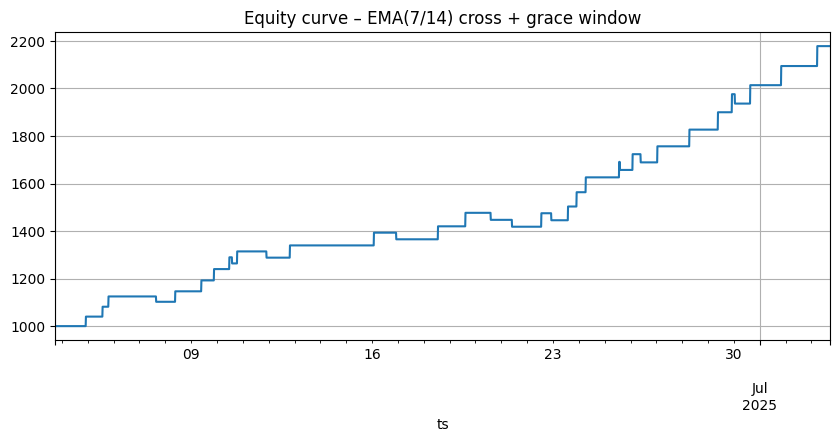

In [4]:
# pip install ccxt pandas numpy matplotlib

import ccxt, pandas as pd, numpy as np, matplotlib.pyplot as plt

# ───────────────── CONFIG ─────────────────────────────────────────
PAIR        = "SOL/USDT"
TF          = "15m"
LOOKBACK_D  = 30             # how many days to fetch

RISK_PCT        = 0.02       # fixed % of equity at risk
ATR_MULT_SL     = 2.0        # SL  = 2×ATR14
ATR_MULT_TP     = 4.0        # TP  = 4×ATR14  (RR 2:1)
WICK_BUFFER     = 0.25       # add 25 % ATR under/over wick
ADX_FLOOR       = 20
STO_K_MIN_LONG  = 45
STO_K_MIN_SHORT = 30
MAX_BARS_AFTER_CROSS = 3     # ← grace window (in 15-m bars)
GOOD_HOURS  = {1,2,3,4, 13,14,15,16,17,18}   # UTC

# ───────────────── DOWNLOAD DATA ─────────────────────────────────
ex, rows = ccxt.bybit(), []
since = ex.milliseconds() - LOOKBACK_D * 86_400_000
while since < ex.milliseconds():
    chunk = ex.fetch_ohlcv(PAIR, TF, since=since, limit=1000)
    if not chunk:
        break
    rows.extend(chunk)
    since = chunk[-1][0] + 1       # next page

df = (pd.DataFrame(rows, columns="ts o h l c v".split())
        .assign(ts=lambda d: pd.to_datetime(d.ts, unit="ms", utc=True))
        .set_index("ts"))

# ───────────────── INDICATORS ───────────────────────────────────
df["ema7"]  = df.c.ewm(span=7).mean()
df["ema14"] = df.c.ewm(span=14).mean()
df["ema28"] = df.c.ewm(span=28).mean()

tr = np.maximum.reduce([df.h - df.l,
                        (df.h - df.c.shift()).abs(),
                        (df.l - df.c.shift()).abs()])
df["atr"] = pd.Series(tr, index=df.index).rolling(14).mean()

delta = df.c.diff()
gain  = delta.clip(lower=0).ewm(alpha=1/14, adjust=False).mean()
loss  = (-delta.clip(upper=0)).ewm(alpha=1/14, adjust=False).mean()
df["rsi"] = 100 - 100 / (1 + gain / loss)

rsi_min = df.rsi.rolling(14).min()
rsi_max = df.rsi.rolling(14).max()
df["k_fast"] = ((df.rsi - rsi_min) / (rsi_max - rsi_min)).rolling(3).mean() * 100

plus_dm  = np.where(df.h.diff() > df.l.diff(), df.h.diff().clip(lower=0), 0)
minus_dm = np.where(df.l.diff() > df.h.diff(), df.l.diff().abs(), 0)
tr_n     = pd.Series(tr, index=df.index).rolling(14).sum()
plus_di  = 100 * pd.Series(plus_dm, index=df.index).rolling(14).sum() / tr_n
minus_di = 100 * pd.Series(minus_dm, index=df.index).rolling(14).sum() / tr_n
dx       = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
df["adx"] = dx.rolling(14).mean()

# ───────────────── HIGHER-TF FILTERS ────────────────────────────
h1 = df.c.resample("1H").last().to_frame("close").ffill()
h1["ema50"] = h1.close.ewm(span=50).mean()
h1["slope"] = h1.ema50.diff(3)

def h1_row(ts):            # helper
    return h1.loc[ts.floor("1H")]

# ───────────────── BACK-TEST LOOP ───────────────────────────────
equity = 1_000.0
pos    = None
trades, curve = [], []

last_cross_up_ts  = None
last_cross_dn_ts  = None

def bars_since(ts_cross, ts_now):
    if ts_cross is None:
        return np.inf
    return (ts_now - ts_cross) / pd.Timedelta(minutes=15)

for i, (idx, bar) in enumerate(df.iterrows()):
    prev = df.iloc[i-1] if i else bar
    h1r  = h1_row(idx)

    # ── track most-recent EMA crosses ───────────────────────────
    if bar.ema7 > bar.ema14 and prev.ema7 <= prev.ema14:
        last_cross_up_ts = idx
    elif bar.ema7 < bar.ema14 and prev.ema7 >= prev.ema14:
        last_cross_dn_ts = idx

    # ── manage open trade ───────────────────────────────────────
    if pos:
        hit_sl = (pos['dir'] ==  1 and bar.l <= pos['sl']) or \
                 (pos['dir'] == -1 and bar.h >= pos['sl'])
        hit_tp = (pos['dir'] ==  1 and bar.h >= pos['tp']) or \
                 (pos['dir'] == -1 and bar.l <= pos['tp'])
        if hit_sl or hit_tp:
            rr   = -1 if hit_sl else ATR_MULT_TP / ATR_MULT_SL
            pnl  = pos['risk'] * rr
            equity += pnl
            direction = "LONG" if pos['dir'] == 1 else "SHORT"
            trades.append({'exit': idx, 'pnl': pnl})
            pos['time_close'] = idx
            print (f"{direction} Trade Entry: {pos['entry']} | Timestamp: {pos['time_entry']}  | Take Proft: {pos['tp']} | Stop Loss: {pos['sl']}  |  PnL: ${pnl:.2f}  |  Equity: ${equity:.2f} | Volume: {bar.v:.0f}")
            if hit_tp:
                print(f"🟢Trade closed: {idx} | Take Profit hit: {pos['time_close']} | Exit: {bar.c} | TP: {pos['tp']}")
            else:
                print(f"🔴Trade closed: {idx} | Stop Loss hit: {pos['time_close']} | Exit: {bar.c} | SL: {pos['sl']}")
            pos = None

    # ── look for new entry ──────────────────────────────────────
    hour_ok = bar.name.hour in GOOD_HOURS
    if pos is None:
        grace_up  = bars_since(last_cross_up_ts, idx)
        grace_dn  = bars_since(last_cross_dn_ts, idx)
        trend_up  = h1r.close > h1r.ema50 and h1r.slope > 0
        trend_dn  = h1r.close < h1r.ema50 and h1r.slope < 0

        long_ok = (
            bar.ema7 > bar.ema14 and
            grace_up <= MAX_BARS_AFTER_CROSS and
            bar.k_fast > STO_K_MIN_LONG and
            bar.rsi    > 45 and
            bar.adx    >= ADX_FLOOR and
            trend_up
        )

        short_ok = (
            bar.ema7 < bar.ema14 and
            grace_dn <= MAX_BARS_AFTER_CROSS and
            bar.k_fast > STO_K_MIN_SHORT and
            bar.rsi    > 30 and
            bar.adx    >= ADX_FLOOR and
            trend_dn
        )

        if long_ok or short_ok:
            dir_  = 1 if long_ok else -1
            stop  = ATR_MULT_SL * bar.atr * 1.6
            entry = bar.c
            pos   = dict(
                dir   = dir_,
                entry = entry,
                sl    = entry - stop - WICK_BUFFER*bar.atr if dir_==1 else entry + stop + WICK_BUFFER*bar.atr,
                tp    = entry + ATR_MULT_TP*bar.atr        if dir_==1 else entry - ATR_MULT_TP*bar.atr,
                risk  = equity * RISK_PCT,
                time_entry= idx,
                time_close=None
            )

    curve.append(equity)

# ───────────────── RESULTS ──────────────────────────────────────
eq_series = pd.Series(curve, index=df.index[-len(curve):])
wins = sum(t['pnl'] > 0 for t in trades)
print(f"Trades: {len(trades)} | Wins: {wins} | Win-rate: {wins/len(trades):.1%}")
print(f"Final balance: ${equity:,.0f} | Max DD: {(min(eq_series)-1_000)/10:.1f}%")

eq_series.plot(title="Equity curve – EMA(7/14) cross + grace window", figsize=(10,4), grid=True)
plt.show()
